In [82]:
# ML methods: linear regression, logistic regression, geographical weighted regression, random forest, support vector machine, neural network

# Load the data

In [7]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
import seaborn as sns
from types import SimpleNamespace
import pyproj
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from mgwr.gwr import GWR
from mgwr.sel_bw import Sel_BW
import pyproj
utm = pyproj.CRS('EPSG:32618')
import pickle 

from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Perceptron
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor

P = SimpleNamespace()
P.data = "../data"
CRS_DEG = 'EPSG:4326'
CRS_M = 'EPSG:3857'
# import chardet
random.seed(42)
np.random.seed(42)
df_input = pd.read_parquet(P.data+"/df_input_merged.parquet")


df_input['POP'] = df_input['e_totpop']
df_input['CASE_0'] = df_input['Cases_wave0']
df_input['CASE_1'] = df_input['Cases_wave1']
df_input['CASE_2'] = df_input['Cases_wave2']
df_input['CASE_3'] = df_input['Cases_wave3']

df_input['RATIO_0'] = df_input['Positive_wave0']*100
df_input['RATIO_1'] = df_input['Positive_wave1']*100
df_input['RATIO_2'] = df_input['Positive_wave2']*100
df_input['RATIO_3'] = df_input['Positive_wave3']*100

df_input['VAC_0'] = df_input['Completed_wave0']
df_input['VAC_1'] = df_input['Completed_wave1']
df_input['VAC_2'] = df_input['Completed_wave2']
df_input['VAC_3'] = df_input['Completed_wave3']

df_input['POP_DENSITY'] = df_input['POP']/df_input['area_sqmi']
# df_input['POP_DENSITY_LOG'] = np.log10(df_input['POP_DENSITY']+1)
df_input['AGE_MINOR'] = df_input['ep_age17']
df_input['AGE_SENIOR'] = df_input['ep_age65']
df_input['RACE_HISP'] = df_input['ep_hisp']
df_input['RACE_AFAM'] = df_input['ep_afam']
df_input['RACE_ASIAN'] = df_input['ep_asian']
df_input['NO_HSDP'] = df_input['ep_nohsdp']
df_input['NO_EMPLOY'] = df_input['ep_unemp']
df_input.loc[df_input['NO_EMPLOY']<0,'NO_EMPLOY'] = np.nan
df_input['POP_POOR'] = df_input['ep_pov150']
df_input['NO_VEH'] = df_input['ep_noveh']
df_input.loc[df_input['NO_VEH']<0,'NO_VEH'] = np.nan
df_input['NO_INSUR'] = df_input['ep_uninsur']
df_input.loc[df_input['NO_INSUR']<0,'NO_INSUR'] = np.nan
df_input['POP_DISABLE'] = df_input['ep_disabl']
df_input.loc[df_input['POP_DISABLE']<0,'POP_DISABLE'] = np.nan

df_input['DIST_IDA'] = df_input['dist_to_Ida']
df_input['DIST_COAST'] = df_input['dist_to_south_bound']
df_input['DIST_NICHOLAS'] = df_input['dist_to_Nicholas']

df_input['EVAC_0'] = df_input['disp_ratio_wave0']
df_input['EVAC_1'] = df_input['disp_ratio_wave1']
df_input['EVAC_2'] = df_input['disp_ratio_wave2']
df_input['EVAC_3'] = df_input['disp_ratio_wave3']

df_input['RETURN_0'] = df_input['return_ratio_wave0_7days']
df_input['RETURN_1'] = df_input['return_ratio_wave1_7days']
df_input['RETURN_2'] = df_input['return_ratio_wave2_7days']
df_input['RETURN_3'] = df_input['return_ratio_wave3_7days']

df_input['DIST_0'] = df_input['dist_wave0'].clip(lower = 1)
df_input['DIST_1'] = df_input['dist_wave1'].clip(lower = 1)
df_input['DIST_2'] = df_input['dist_wave2'].clip(lower = 1)
df_input['DIST_3'] = df_input['dist_wave3'].clip(lower = 1)

df_input['DURATION_0'] = df_input['duration_wave0']
df_input['DURATION_1'] = df_input['duration_wave1']
df_input['DURATION_2'] = df_input['duration_wave2']
df_input['DURATION_3'] = df_input['duration_wave3']

df_input['URBAN'] = df_input['urban'].astype(int)

merged_tract = gpd.read_file(P.data + '/map/merged_tract.gpkg')
merged_tract = merged_tract[['id','geometry']].to_crs(CRS_M)

df_input = pd.merge(merged_tract, df_input, on = 'id').set_geometry('geometry')

df_input.dropna(inplace= True)


normalize_factors =  ['DIST_IDA', 'DIST_COAST',  \
                        'CASE_0', 'VAC_0', \
                  'CASE_1', 'VAC_1', \
                  'CASE_2', 'VAC_2', \
                  'CASE_3', 'VAC_3', \
                  'AGE_MINOR', 'AGE_SENIOR', \
                  'RACE_HISP', 'RACE_AFAM', 'RACE_ASIAN', \
                  'NO_HSDP', 'NO_EMPLOY',  'NO_VEH', 'NO_INSUR', 'POP_DISABLE', 'POP_POOR', \
                  ]
factors = normalize_factors + ['URBAN']
targets = ['EVAC_0', 'RETURN_0', 'DIST_0', 'DURATION_0',\
      'EVAC_1', 'RETURN_1', 'DIST_1', 'DURATION_1',\
      'EVAC_2', 'RETURN_2', 'DIST_2', 'DURATION_2',\
      'EVAC_3', 'RETURN_3', 'DIST_3', 'DURATION_3']

# Load results

In [8]:
res = {}

for seed in range(5):
      for ratio in np.arange(100, 110, 10):
            for covid in ['False', 'True']:
                  with open(P.data + f'/res_{ratio}_{covid}_{seed}.pkl', 'rb') as f:
                        res[(seed, ratio, covid)] = pickle.load(f)

# Performance table

In [42]:
sep = ' & '

covid = 'True'
models = ['linear', 'logit', 'rf', 'xgb', 'svm', 'nn']
models_print = ['Linear','Logistic', 'RF','XGB', 'SVR', 'NN']
# wave, target, lr, SVR, RF, NN, avg and std over 5 seeds, ratio = 100, MSE and wMAPE
for model, model_print in zip(models, models_print):
      mse = []
      # mape = []
      k = 0
      for target in ['EVAC    ', 'RETURN', 'DIST    ', 'DURATION']:
            for wave in [1,2,3]:
                  tmp = 0
                  for fold in range(5):
                        tmp += res[(fold, 100, covid)][f'{model}_{wave*4+k}'][0][1]
                  mse.append('{0:.3f}'.format(np.sqrt(tmp/len(df_input))))
                  # mape.append(res[(seed, 100, covid)][f'{model}_{wave*4+k}'][0][4])
            k += 1
      one_row = f'{sep} {model_print} {sep} {sep.join(mse)} \\\\'

      if model == 'linear':
            print(f'RMSE  {sep} {one_row}')
      else:
            print(f'      {sep} {one_row}')

for model, model_print in zip(models, models_print):
      # mse = []
      mape = []
      k = 0
      for target in ['EVAC    ', 'RETURN', 'DIST    ', 'DURATION']:
            for wave in [1,2,3]:
                  tmp = 0
                  tmp2 = 0
                  for fold in range(5):
                        tmp += res[(seed, 100, covid)][f'{model}_{wave*4+k}'][0][0]
                        tmp2 += res[(seed, 100, covid)][f'{model}_{wave*4+k}'][0][4]
                  # mse.append(res[(seed, 100, covid)][f'{model}_{wave*4+k}'][0][1])
                  mape.append('{0:.3f}'.format(tmp/tmp2*100))
            k += 1
      one_row = f'{sep} {model_print} {sep} {sep.join(mape)} \\\\'

      if model == 'linear':
            print(f'WMAPE {sep} {one_row}')
      else:
            print(f'      {sep} {one_row}')

RMSE   &   &  Linear  &  1.469 & 1.541 & 1.206 & 6.415 & 5.201 & 3.632 & 11.715 & 12.916 & 9.735 & 2.502 & 2.070 & 1.838 \\
       &   &  Logistic  &  1.470 & 1.588 & 1.217 & 6.459 & 5.277 & 6.442 & 11.503 & 12.597 & 9.539 & 2.508 & 2.063 & 1.844 \\
       &   &  RF  &  1.399 & 1.478 & 1.135 & 6.200 & 5.110 & 3.541 & 10.936 & 9.497 & 9.386 & 2.404 & 2.135 & 1.845 \\
       &   &  XGB  &  1.409 & 1.483 & 1.148 & 6.345 & 5.077 & 3.627 & 11.808 & 10.025 & 9.332 & 2.420 & 2.082 & 1.855 \\
       &   &  SVR  &  1.435 & 1.522 & 1.150 & 6.206 & 5.319 & 3.559 & 11.786 & 11.090 & 9.833 & 2.386 & 2.151 & 1.830 \\
       &   &  NN  &  1.492 & 1.643 & 1.214 & 6.336 & 5.909 & 3.716 & 11.854 & 10.947 & 10.646 & 2.651 & 2.237 & 1.844 \\
WMAPE  &   &  Linear  &  14.261 & 13.879 & 15.355 & 8.106 & 5.166 & 2.804 & 29.692 & 35.166 & 32.995 & 11.887 & 10.237 & 15.923 \\
       &   &  Logistic  &  14.196 & 13.739 & 15.094 & 8.027 & 4.871 & 5.560 & 29.283 & 33.537 & 30.783 & 11.892 & 10.161 & 15.824 \\
    

In [45]:
sep = ' & '

covid = 'False'
models = ['linear', 'logit', 'rf', 'xgb', 'svm', 'nn']
# wave, target, lr, SVR, RF, NN, avg and std over 5 seeds, ratio = 100, MSE and wMAPE
for model, model_print in zip(models, models_print):
      mse = []
      # mape = []
      k = 0
      for target in ['EVAC    ', 'RETURN', 'DIST    ', 'DURATION']:
            for wave in [1,2,3]:
                  tmp = 0
                  for fold in range(5):
                        tmp += res[(fold, 100, covid)][f'{model}_{wave*4+k}'][0][1]
                  mse.append('{0:.4f}'.format(np.sqrt(tmp/len(df_input))))
                  # mape.append(res[(seed, 100, covid)][f'{model}_{wave*4+k}'][0][4])
            k += 1
      one_row = f'{sep} {model_print} {sep} {sep.join(mse)} \\\\'

      if model == 'linear':
            print(f'RMSE  {sep} {one_row}')
      else:
            print(f'      {sep} {one_row}')

for model, model_print in zip(models, models_print):
      # mse = []
      mape = []
      k = 0
      for target in ['EVAC    ', 'RETURN', 'DIST    ', 'DURATION']:
            for wave in [1,2,3]:
                  tmp = 0
                  tmp2 = 0
                  for fold in range(5):
                        tmp += res[(seed, 100, covid)][f'{model}_{wave*4+k}'][0][0]
                        tmp2 += res[(seed, 100, covid)][f'{model}_{wave*4+k}'][0][4]
                  # mse.append(res[(seed, 100, covid)][f'{model}_{wave*4+k}'][0][1])
                  mape.append('{0:.3f}'.format(tmp/tmp2*100,2))
            k += 1
      one_row = f'{sep} {model_print} {sep} {sep.join(mape)} \\\\'

      if model == 'linear':
            print(f'WMAPE {sep} {one_row}')
      else:
            print(f'      {sep} {one_row}')

RMSE   &   &  Linear  &  1.5432 & 1.5902 & 1.2050 & 6.5445 & 5.2389 & 3.6147 & 11.6976 & 12.9876 & 9.7176 & 2.4967 & 2.0922 & 1.8338 \\
       &   &  Logistic  &  1.5426 & 1.6225 & 1.2133 & 6.5490 & 5.2467 & 8.2964 & 11.3847 & 12.3267 & 9.5431 & 2.4945 & 2.0807 & 1.8393 \\
       &   &  RF  &  1.4307 & 1.5373 & 1.1791 & 6.1477 & 5.0886 & 3.5919 & 11.2162 & 9.8664 & 9.2972 & 2.4202 & 2.0866 & 1.8463 \\
       &   &  XGB  &  1.4552 & 1.5413 & 1.1759 & 6.3435 & 4.9556 & 3.5924 & 11.7359 & 10.5416 & 9.6380 & 2.4124 & 2.0812 & 1.8571 \\
       &   &  SVR  &  1.4387 & 1.5598 & 1.1728 & 6.1848 & 5.3706 & 3.5471 & 11.7256 & 11.7013 & 9.9330 & 2.4115 & 2.1669 & 1.8266 \\
       &   &  NN  &  1.4303 & 1.6872 & 1.1859 & 6.3031 & 5.4863 & 3.6211 & 11.1069 & 11.0910 & 10.1853 & 2.5279 & 2.2699 & 1.9374 \\
WMAPE  &   &  Linear  &  14.746 & 13.857 & 15.137 & 8.201 & 5.178 & 2.894 & 30.004 & 34.631 & 33.493 & 11.898 & 10.384 & 15.722 \\
       &   &  Logistic  &  14.753 & 14.105 & 15.107 & 8.090 & 4.9

Nonlinear model is better than linear model. More importantly, the benefit of COVID-related factors seem more salient in nonlinear model, suggesting the COVID factors' impacts are nonlinear.

# SHAP values for different seeds and different ML models (linear model is not working)

In [14]:
# import shap

# res2 = {}
# ratio = 100
# for k in range(4, 16):
#       for seed in range(5):
#             for covid in ['False', 'True']:
#                   # xgboost
#                   data = res[(seed, ratio, covid)][f'xgb_{k}']
#                   df = df_input.copy()
#                   df[normalize_factors] = data[2].transform(df[normalize_factors])
#                   explainer = shap.TreeExplainer(data[1], df[data[-2]])
#                   res2[(seed, covid, 'xgb', k)] = np.array(explainer.shap_values(df[data[-2]], check_additivity=False))
#                   # random forest
#                   data = res[(seed, ratio, covid)][f'rf_{k}']
#                   df = df_input.copy()
#                   df[normalize_factors] = data[2].transform(df[normalize_factors])
#                   explainer = shap.TreeExplainer(data[1], df[data[-2]])
#                   res2[(seed, covid, 'rf', k)] = np.array(explainer.shap_values(df[data[-2]], check_additivity=False))
#                   # svr
#                   data = res[(seed, ratio, covid)][f'svm_{k}']
#                   df = df_input.copy()
#                   df[normalize_factors] = data[2].transform(df[normalize_factors])
#                   def f(X):
#                         return data[1].predict(X).flatten()
#                   explainer = shap.KernelExplainer(f, shap.kmeans(df[data[-2]], 10).data, data[-2])
#                   res2[(seed, covid, 'svm',k)] = np.array(explainer.shap_values(df[data[-2]]))
#                   # neural network
#                   data = res[(seed, ratio, covid)][f'nn_{k}']
#                   df = df_input.copy()
#                   df[normalize_factors] = data[2].transform(df[normalize_factors])
#                   def f(X):
#                         return data[1].predict(X).flatten()
#                   explainer = shap.KernelExplainer(f, shap.kmeans(df[data[-2]], 10).data, data[-2])
#                   res2[(seed, covid, 'nn',k)] = np.array(explainer.shap_values(df[data[-2]]))
                   
# # save the results in pickle files
# with open(P.data + f'/res2_{ratio}.pkl', 'wb') as f:  
#       pickle.dump(res2, f)

In [18]:
ratio = 100
# load the results
with open(P.data + f'/res2_{ratio}.pkl', 'rb') as f:
      res2 = pickle.load(f)

# Similarity among SHAP values

In [19]:
# Within/Between model similarity
k = 0

data = np.zeros((5, 5, 16, 16))
seeds = [0,1,2,3,4]

# i is seed1, j is seed2, k is target
for i in range(5):
      for j in range(5):
            for k in range(4,16):
                  seed1 = seeds[i]
                  seed2 = seeds[j]
                  # using cosine similarity
                  data[i, j, 0, k] = np.dot(res2[(seed1, 'True', 'rf', k)].flatten(), res2[(seed2, 'True', 'rf', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'rf', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'rf', k)].flatten()))
                  data[i, j, 1, k] = np.dot(res2[(seed1, 'True', 'rf', k)].flatten(), res2[(seed2, 'True', 'xgb', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'rf', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'xgb', k)].flatten()))
                  data[i, j, 2, k] = np.dot(res2[(seed1, 'True', 'rf', k)].flatten(), res2[(seed2, 'True', 'svm', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'rf', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'svm', k)].flatten()))
                  data[i, j, 3, k] = np.dot(res2[(seed1, 'True', 'rf', k)].flatten(), res2[(seed2, 'True', 'nn', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'rf', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'nn', k)].flatten()))
                  
                  data[i, j, 4, k] = np.dot(res2[(seed1, 'True', 'xgb', k)].flatten(), res2[(seed2, 'True', 'rf', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'xgb', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'rf', k)].flatten()))
                  data[i, j, 5, k] = np.dot(res2[(seed1, 'True', 'xgb', k)].flatten(), res2[(seed2, 'True', 'xgb', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'xgb', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'xgb', k)].flatten()))
                  data[i, j, 6, k] = np.dot(res2[(seed1, 'True', 'xgb', k)].flatten(), res2[(seed2, 'True', 'svm', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'xgb', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'svm', k)].flatten()))
                  data[i, j, 7, k] = np.dot(res2[(seed1, 'True', 'xgb', k)].flatten(), res2[(seed2, 'True', 'nn', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'xgb', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'nn', k)].flatten()))

                  data[i, j, 8, k] = np.dot(res2[(seed1, 'True', 'svm', k)].flatten(), res2[(seed2, 'True', 'rf', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'svm', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'rf', k)].flatten()))
                  data[i, j, 9, k] = np.dot(res2[(seed1, 'True', 'svm', k)].flatten(), res2[(seed2, 'True', 'xgb', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'svm', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'xgb', k)].flatten()))
                  data[i, j, 10, k] = np.dot(res2[(seed1, 'True', 'svm', k)].flatten(), res2[(seed2, 'True', 'svm', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'svm', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'svm', k)].flatten()))
                  data[i, j, 11, k] = np.dot(res2[(seed1, 'True', 'svm', k)].flatten(), res2[(seed2, 'True', 'nn', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'svm', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'nn', k)].flatten()))

                  data[i, j, 12, k] = np.dot(res2[(seed1, 'True', 'nn', k)].flatten(), res2[(seed2, 'True', 'rf', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'nn', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'rf', k)].flatten()))
                  data[i, j, 13, k] = np.dot(res2[(seed1, 'True', 'nn', k)].flatten(), res2[(seed2, 'True', 'xgb', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'nn', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'xgb', k)].flatten()))
                  data[i, j, 14, k] = np.dot(res2[(seed1, 'True', 'nn', k)].flatten(), res2[(seed2, 'True', 'svm', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'nn', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'svm', k)].flatten()))
                  data[i, j, 15, k] = np.dot(res2[(seed1, 'True', 'nn', k)].flatten(), res2[(seed2, 'True', 'nn', k)].flatten())/(np.linalg.norm(res2[(seed1, 'True', 'nn', k)].flatten())*np.linalg.norm(res2[(seed2, 'True', 'nn', k)].flatten()))

In [20]:
# data = data[:,:,[0,1,3,4],:]

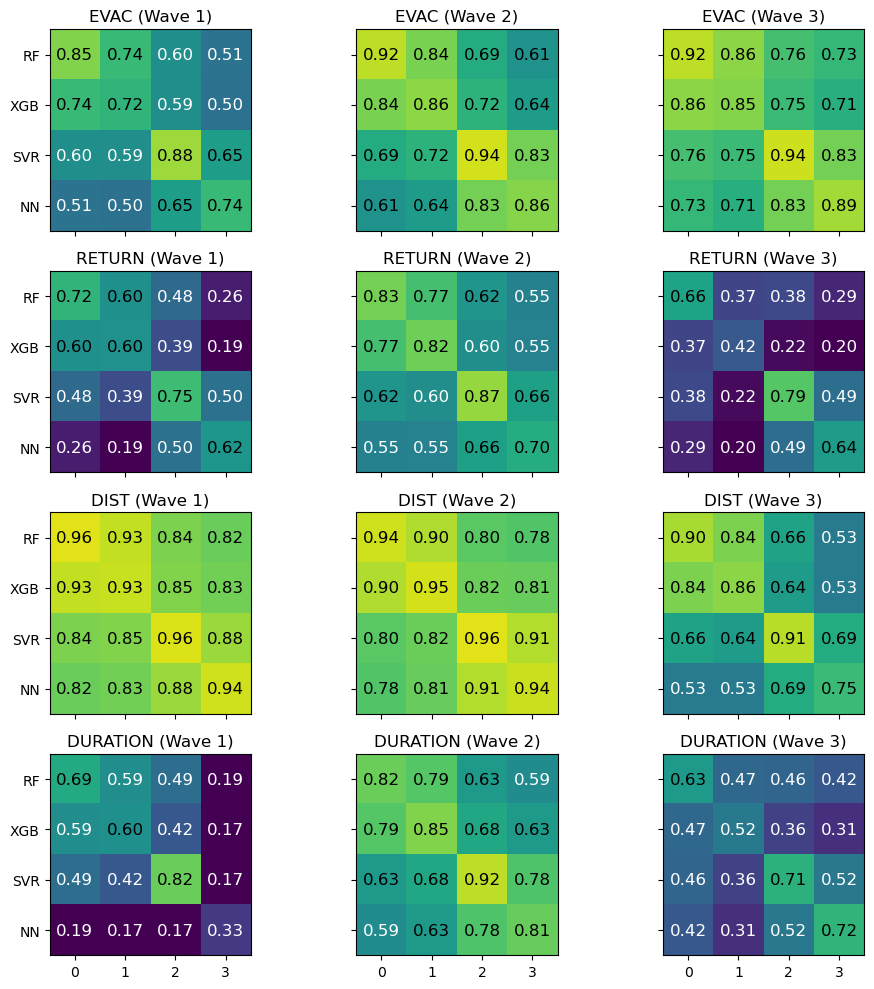

In [21]:
# Two groups of targets
group1 = []
group2 = []
group3 = []

names = ['EVAC (Overall)', 'RETURN (Overall)', 'DIST (Overall)', 'DURATION (Overall)',\
         'EVAC (Wave 1)', 'RETURN (Wave 1)', 'DIST (Wave 1)', 'DURATION (Wave 1)',\
      'EVAC (Wave 2)', 'RETURN (Wave 2)', 'DIST (Wave 2)', 'DURATION (Wave 2)',\
      'EVAC (Wave 3)', 'RETURN (Wave 3)', 'DIST (Wave 3)', 'DURATION (Wave 3)']

fig, axs = plt.subplots(4, 3, figsize = (10, 10), sharex= True, sharey = True)

for k in range(4,16):
      axs[k%4, k//4-1].imshow(np.mean(data[:,:,:,k], axis = (0,1)).reshape(4,4), vmin = 0.2, vmax = 1)

      # fille the text 
      for i in range(4):
            for j in range(4):
                  # if > 0.5, fill with black
                  if np.mean(data[:,:,:,k], axis = (0,1)).reshape(4,4)[i,j] > 0.6:
                        axs[k%4, k//4-1].text(j, i, f'{np.mean(data[:,:,:,k], axis = (0,1)).reshape(4,4)[i,j]:.2f}', ha="center", va="center", color="k", fontsize = 12)
                  else:
                        axs[k%4, k//4-1].text(j, i, f'{np.mean(data[:,:,:,k], axis = (0,1)).reshape(4,4)[i,j]:.2f}', ha="center", va="center", color="w", fontsize = 12)
      
      axs[k%4, k//4-1].set_title(names[k])

      # label the x and y ticks with the names of the models, RF, SVR, NN
      # axs[3, k%4].set_xticks([0,1,2,3])
      # axs[3, k%4].set_xticklabels(['RF', 'XGB', 'SVR', 'NN'])
      axs[k//4, 0].set_yticks([0,1,2,3])
      axs[k//4, 0].set_yticklabels(['RF', 'XGB', 'SVR', 'NN'])

plt.tight_layout()

plt.savefig('../figs/shap_similarity.png', dpi = 300)
plt.savefig('../figs/shap_similarity.pdf', dpi = 300)
      


In [22]:
# within different random seeds, NN is less stable,DURATION is less stable.

# Variable importance via model values and shap values

In [25]:
import shap

In [26]:
def find_ind(factor, factors):
      for i in range(len(factors)):
            if factors[i] in factor:
                  return i

In [27]:
# X is vriable, Y is target, take the mean of different seeds
# data should be num_factor * num_target

seeds = [0,1,2,3,4]

selected_factors = ['DIST_IDA', 'DIST_COAST',  \
           'CASE', 'VAC', \
            'URBAN',\
            'AGE_MINOR', \
            'AGE_SENIOR', \
            'RACE_HISP', \
            'RACE_AFAM', \
            'RACE_ASIAN', \
            'NO_HSDP',\
            'NO_INSUR',\
            'NO_EMPLOY', \
            'NO_VEH',\
            'POP_DISABLE',\
            'POP_POOR']

data = np.zeros((4, len(selected_factors), len(targets)))
data2 = np.zeros((4, len(selected_factors), len(targets)))
data3 = np.ones((4, len(selected_factors), len(targets)))

# rf, svr
for k in range(4, 16):
      for seed in seeds:
            ind = []
            for factor in res[(seed, 100, 'True')][f'rf_{k}'][4]:
                  ind.append(find_ind(factor, selected_factors))
            data[0, ind, k] += np.mean(np.abs(res2[(seed, 'True', 'rf', k)]), axis = 0) * res[(seed, 100, 'True')][f'rf_{k}'][3].scale_[0]
            data[1, ind, k] += np.mean(np.abs(res2[(seed, 'True', 'xgb', k)]), axis = 0) * res[(seed, 100, 'True')][f'xgb_{k}'][3].scale_[0]
            data[2, ind, k] += np.mean(np.abs(res2[(seed, 'True', 'svm', k)]), axis = 0) * res[(seed, 100, 'True')][f'svm_{k}'][3].scale_[0]
            data[3, ind, k] += np.mean(np.abs(res2[(seed, 'True', 'nn', k)]), axis = 0) * res[(seed, 100, 'True')][f'nn_{k}'][3].scale_[0]
            
            # data2 store the min and max
            # data2[0, ind, k] = np.maximum(data2[0, ind, k], np.mean(np.abs(res2[(seed, 'True', 'rf', k)]), axis = 0)* res[(seed, 100, 'True')][f'rf_{k}'][3].scale_[0])
            # data2[1, ind, k] = np.maximum(data2[1, ind, k], np.mean(np.abs(res2[(seed, 'True', 'xgb', k)]), axis = 0)* res[(seed, 100, 'True')][f'xgb_{k}'][3].scale_[0])
            # data2[2, ind, k] = np.maximum(data2[2, ind, k], np.mean(np.abs(res2[(seed, 'True', 'svm', k)]), axis = 0)* res[(seed, 100, 'True')][f'svm_{k}'][3].scale_[0])
            # data2[3, ind, k] = np.maximum(data2[3, ind, k], np.mean(np.abs(res2[(seed, 'True', 'nn', k)]), axis = 0)* res[(seed, 100, 'True')][f'nn_{k}'][3].scale_[0])

            # data3[0, ind, k] = np.minimum(data3[0, ind, k], np.mean(np.abs(res2[(seed, 'True', 'rf', k)]), axis = 0)* res[(seed, 100, 'True')][f'rf_{k}'][3].scale_[0])
            # data3[1, ind, k] = np.minimum(data3[1, ind, k], np.mean(np.abs(res2[(seed, 'True', 'xgb', k)]), axis = 0)* res[(seed, 100, 'True')][f'xgb_{k}'][3].scale_[0])
            # data3[2, ind, k] = np.minimum(data3[2, ind, k], np.mean(np.abs(res2[(seed, 'True', 'svm', k)]), axis = 0)* res[(seed, 100, 'True')][f'svm_{k}'][3].scale_[0])
            # data3[3, ind, k] = np.minimum(data3[3, ind, k], np.mean(np.abs(res2[(seed, 'True', 'nn', k)]), axis = 0)* res[(seed, 100, 'True')][f'nn_{k}'][3].scale_[0])
            
      data[0, :, k] /= len(seeds)
      data[1, :, k] /= len(seeds)
      data[2, :, k] /= len(seeds)
      data[3, :, k] /= len(seeds)

In [28]:
names = ['EVAC (Overall)', 'RETURN (Overall)', 'DIST (Overall)', 'CYCLE (Overall)',\
         'EVAC (Wave 1)', 'RETURN (Wave 1)', 'DIST (Wave 1)', 'CYCLE (Wave 1)',\
      'EVAC (Wave 2)', 'RETURN (Wave 2)', 'DIST (Wave 2)', 'CYCLE (Wave 2)',\
      'EVAC (Wave 3)', 'RETURN (Wave 3)', 'DIST (Wave 3)', 'CYCLE (Wave 3)']

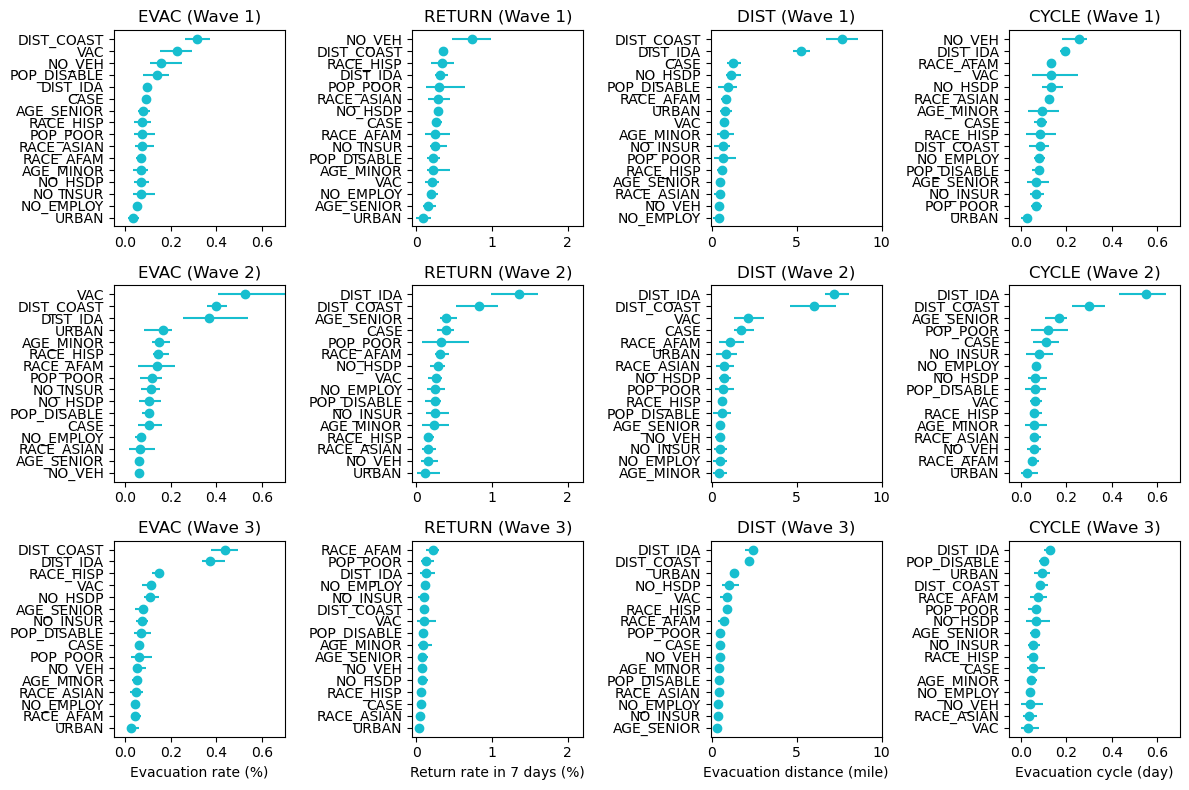

In [30]:
# Tree-based models, mean of the absolute SHAP values among RF and XGB
# ks = [4,8,12,0,5,9,13,1,6,10,14,2,7,11,15,3]
ks = [4,8,12,5,9,13,6,10,14,7,11,15]

selected_targets = [target for target in targets]

fig, axs = plt.subplots(3, 4, figsize = (12, 8))

i = 0
for k in ks:
    plot_data = (data[0, :, k] + data[1, :, k] + data[2, :, k] + data[3, :, k])/4
    plot_data2 = np.maximum(np.maximum(np.maximum(data[0, :, k], data[1, :, k]), data[2, :, k]),data[3, :, k])
    plot_data3 = np.minimum(np.minimum(np.minimum(data[0, :, k], data[1, :, k]), data[2, :, k]),data[3, :, k])
    rank = np.argsort(plot_data).argsort()

    # if k // 4 == 1: # the first value is ignored\
    #    plot_factors = selected_factors[1:]
    #    plot_data = plot_data[1:]
    #    plot_data2 = plot_data2[1:]
    #    plot_data3 = plot_data3[1:]
    #    rank = rank[1:]
    # else:
    plot_factors = selected_factors
    
    # sort plot_factors by rank
    plot_factors = [x for _, x in sorted(zip(rank, plot_factors))]
    plot_data = np.array([x for _, x in sorted(zip(rank, plot_data))])
    plot_data2 =  np.array([x for _, x in sorted(zip(rank, plot_data2))])
    plot_data3 =  np.array([x for _, x in sorted(zip(rank, plot_data3))])
    #  axs[i // 4, i % 4].barh(plot_factors, plot_data, color = 'C9')
    axs[i % 3, i // 3].set_title(names[k])
    # errorbar
    axs[i % 3, i // 3].errorbar(plot_data, plot_factors, xerr = [plot_data - plot_data3, plot_data2 - plot_data], fmt = 'o', color = 'C9')

    # set min y to 0
    if i // 3 == 0:
      if i % 3 <= 2:
         axs[i % 3, i // 3].set_xlim(-0.05, 0.7)
      else:
         axs[i % 3, i // 3].set_xlim(-0.05, 1.8)
      axs[2, i // 3].set_xlabel("Evacuation rate (%)")
    elif i // 3 == 1:
      axs[i % 3, i // 3].set_xlim(-0.05, 2.2)
      axs[2, i // 3].set_xlabel("Return rate in 7 days (%)")
    elif i // 3 == 2:
      axs[i % 3, i // 3].set_xlim(-0.05, 10)
      axs[2, i // 3].set_xlabel("Evacuation distance (mile)")
    else:
      axs[i % 3, i // 3].set_xlim(-0.05, 0.7)
      axs[2, i // 3].set_xlabel("Evacuation cycle (day)")
   
       
    i += 1

# add grid

plt.tight_layout()

plt.savefig('../figs/shap_importance.png', dpi = 300)
plt.savefig('../figs/shap_importance.pdf', dpi = 300)

# The nonlinear effect

In [31]:
import matplotlib as mpl

Put one in the appendix.

In [32]:
from scipy.optimize import curve_fit

def exp(x, a, b, c):
      return a * np.exp(b * x) + c

def linear(x, a, b):
      return a * x + b

def parabola(x, a, b, c):
      return a * x**2 + b * x + c

In [34]:
from matplotlib import cm

In [35]:
# model = 'rf'

# k = 10

# fig, ax = plt.subplots(figsize = (6,6), subplot_kw={'projection': '3d'})

# data = np.zeros(res2[(seed, 'True', model, k)].shape)
# for seed in seeds:
#       data += res2[(seed, 'True', model, k)]
# data /= len(seeds)

# z = data[:, res[(seed, 100, 'True')][f'{model}_{k}'][-1].index(f'CASE_{k//4}')] + data[:, res[(seed, 100, 'True')][f'{model}_{k}'][-1].index(f'VAC_{k//4}')]
# x = df_input[f'CASE_{k//4}'].values
# y = df_input[f'VAC_{k//4}'].values

# ax.plot_trisurf(x, y, z, vmin=z.min() * 2, cmap=cm.RdYlBu_r, edgecolor='none', antialiased=False, alpha = 0.8)

# ax.view_init(10, 100)

# ax.set_xlabel("COVID-19 case rate (%)")
# ax.set_ylabel("COVID-19 vaccination rate (%)")
# ax.set_zlabel("SHAP Value")

# plt.tight_layout()

# plt.show()

x: HURRICANE SHAP
y COVID-19 SHAP

In [46]:
factors = ['DIST_IDA', 'DIST_COAST',  \
           'CASE', 'VAC', \
            'URBAN',\
            'AGE_MINOR', \
            'AGE_SENIOR', \
            'RACE_HISP', \
            'RACE_AFAM', \
            'RACE_ASIAN', \
            'NO_HSDP',\
            'NO_INSUR',\
            'NO_EMPLOY', \
            'NO_VEH',\
            'POP_DISABLE',\
            'POP_POOR']


# factors = ['CASE','VAC']

In [47]:
# model in ['rf', 'xgb', 'svm', 'nn']

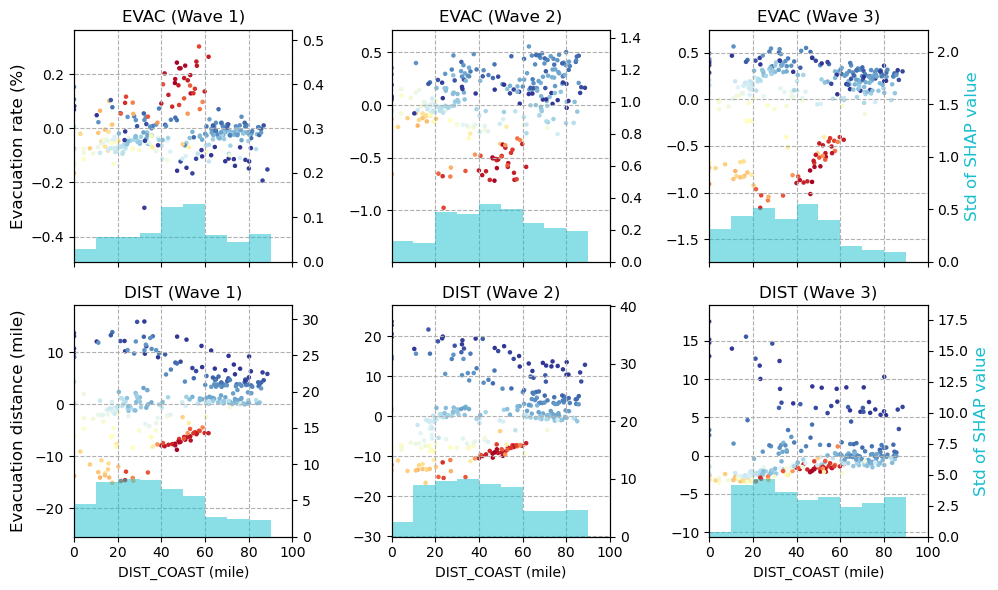

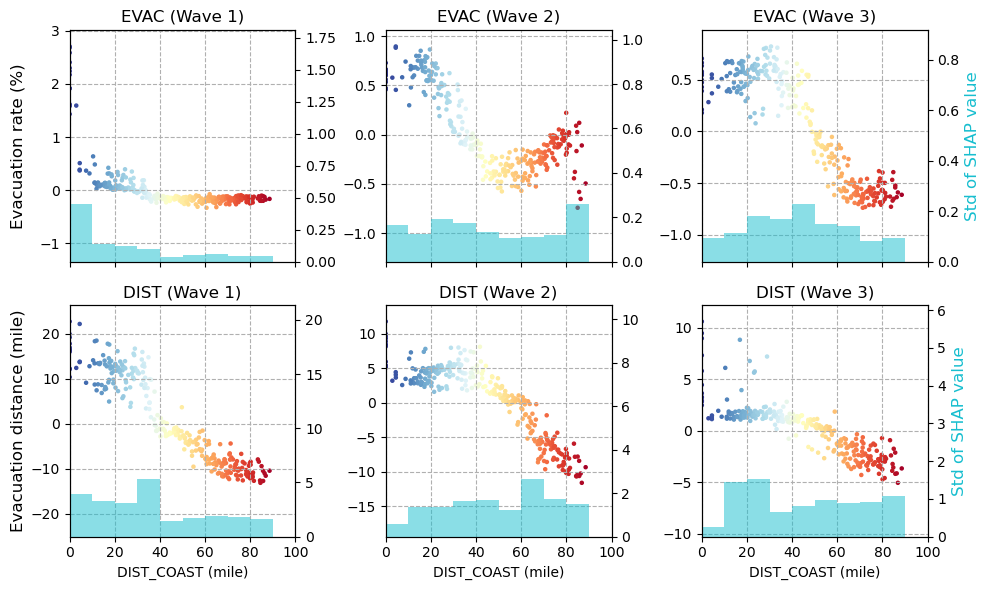

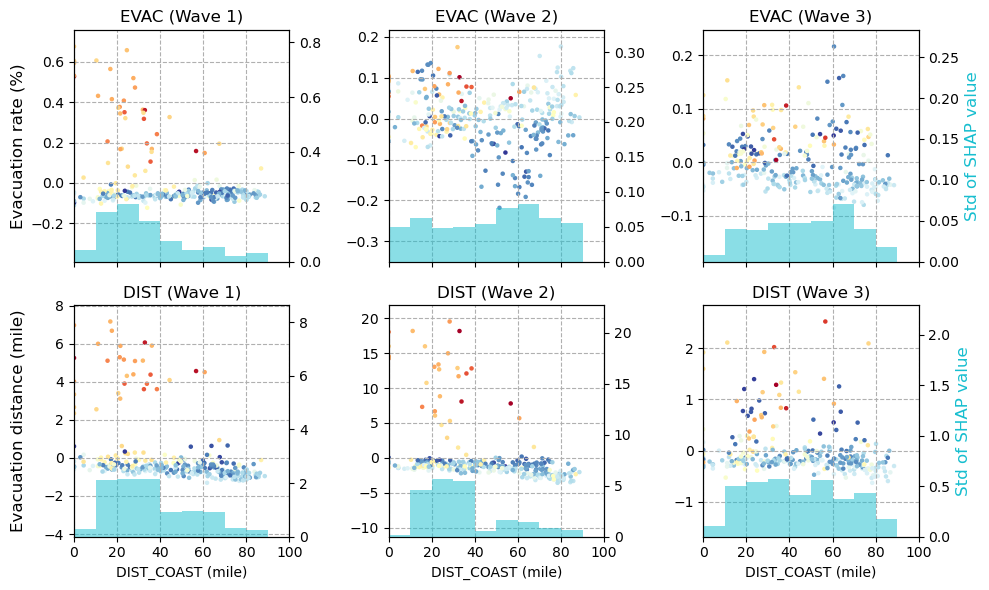

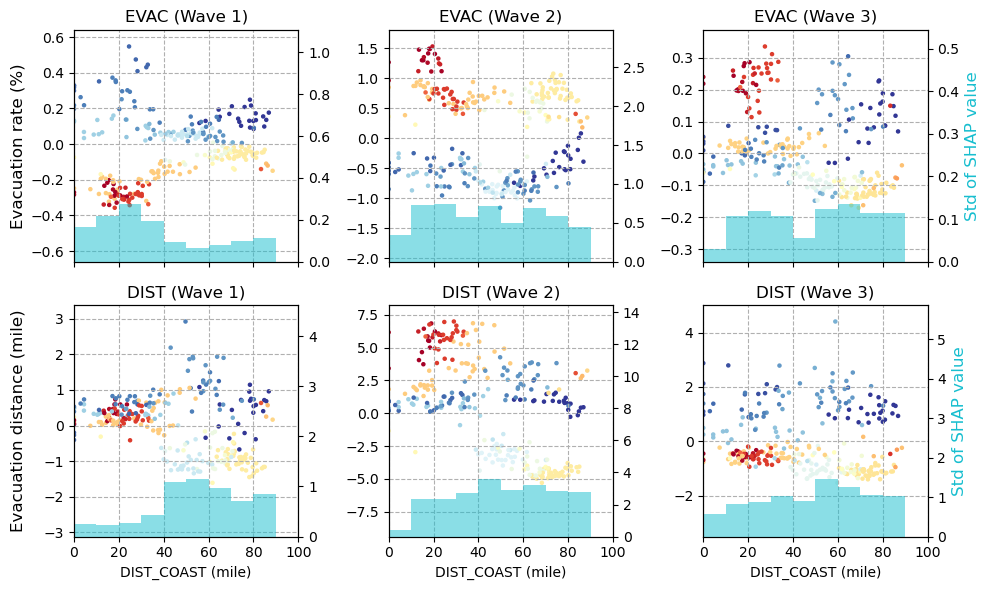

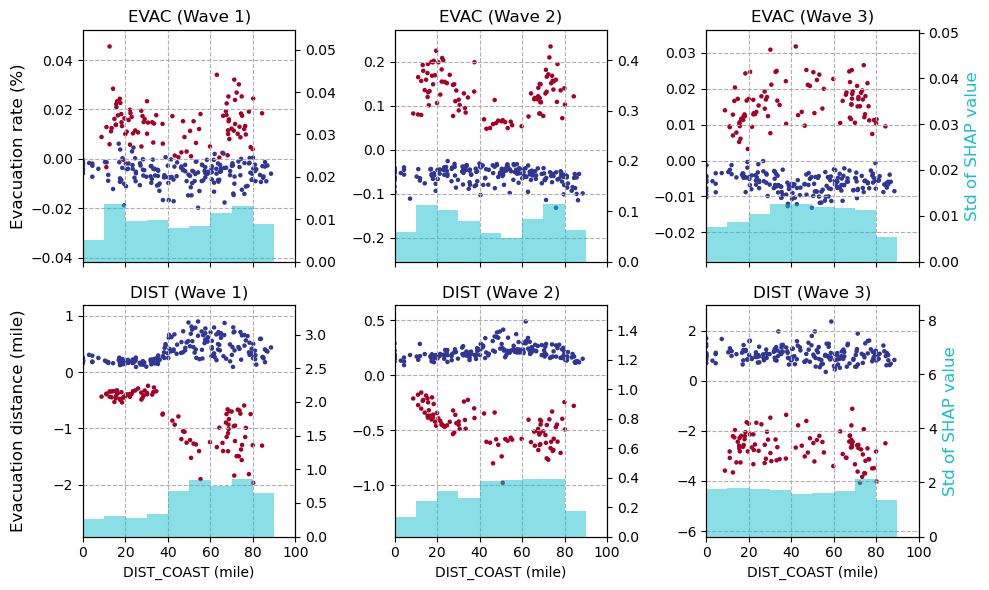

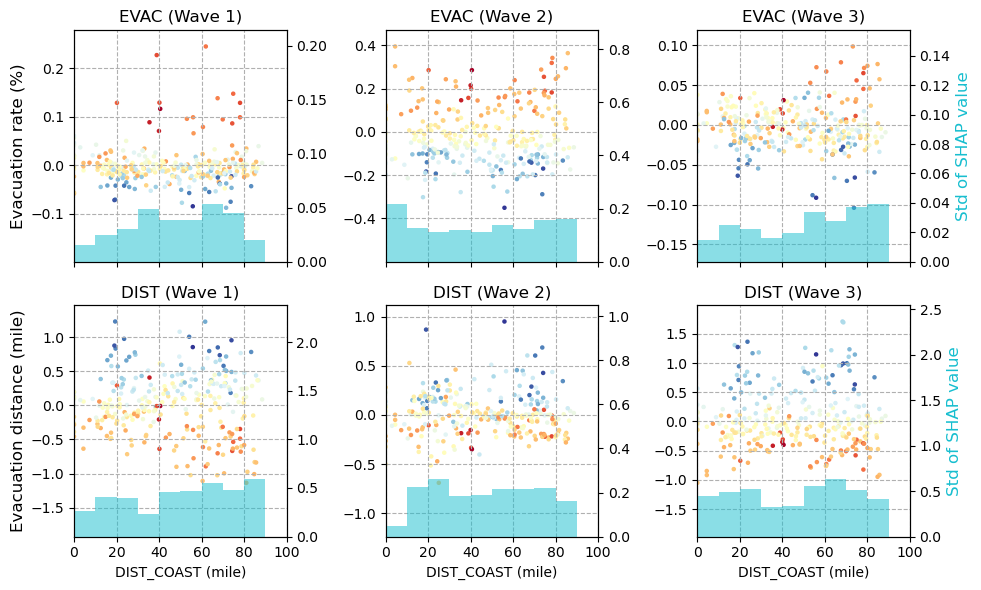

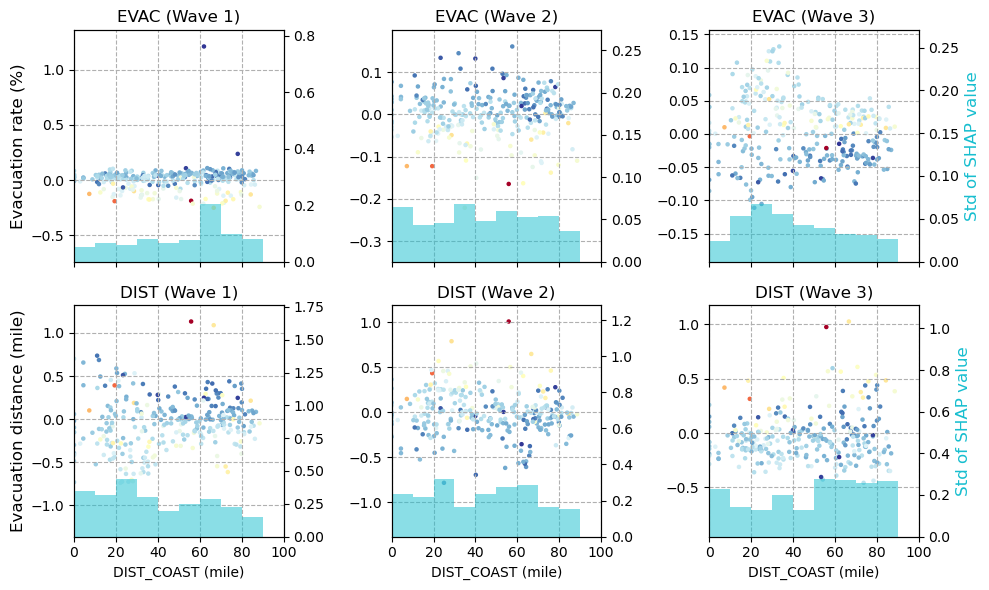

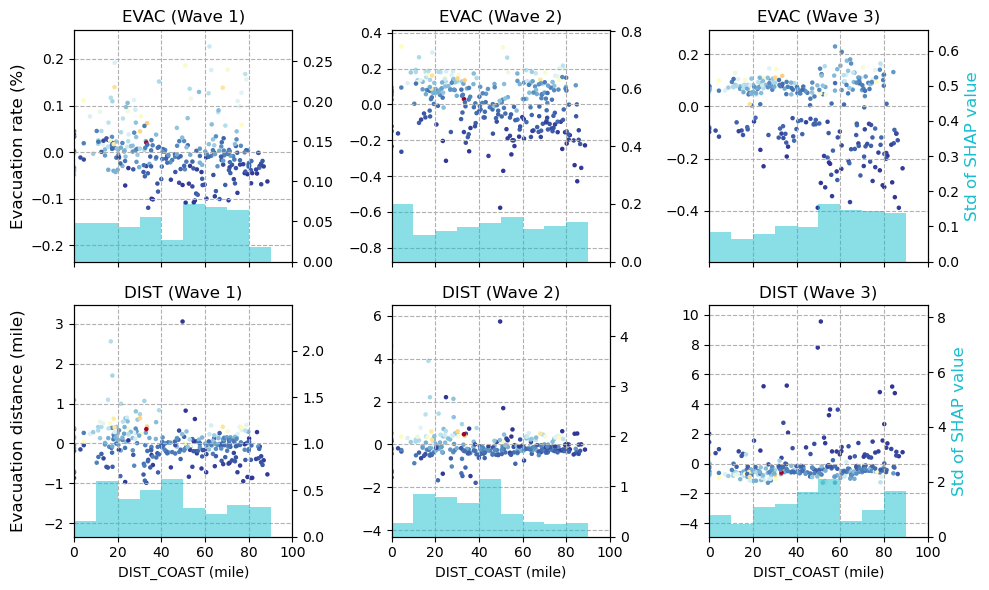

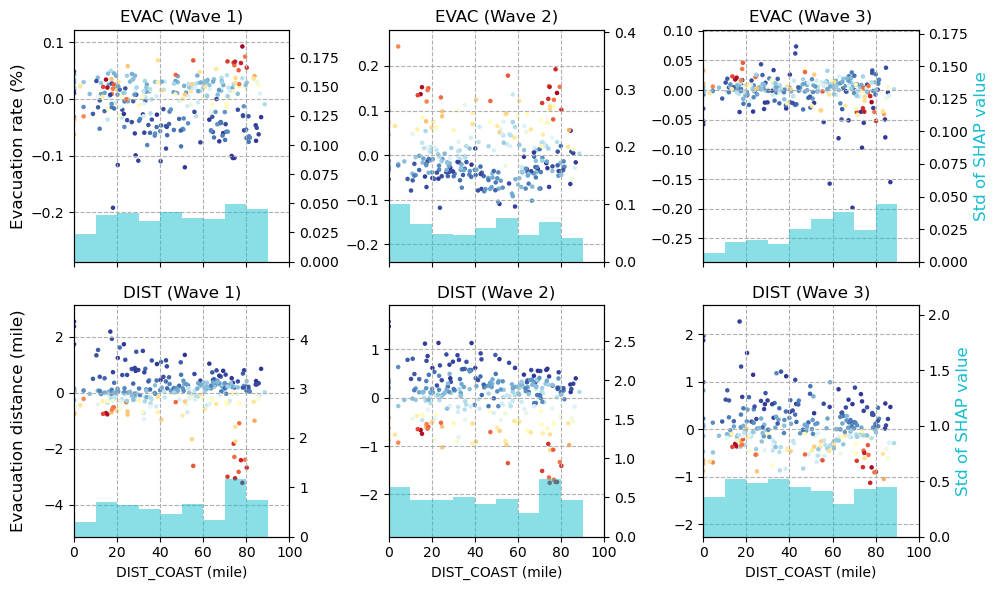

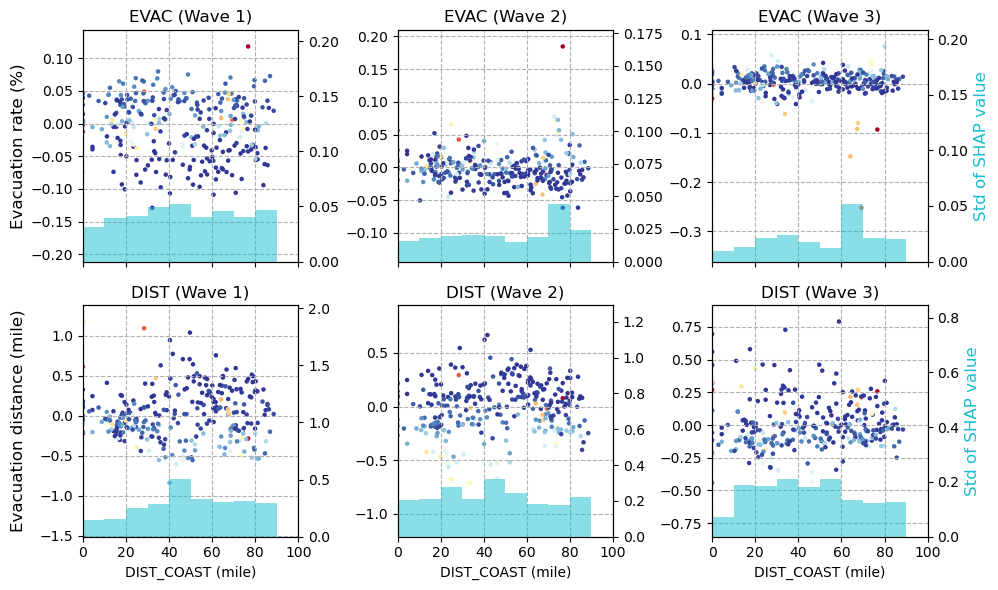

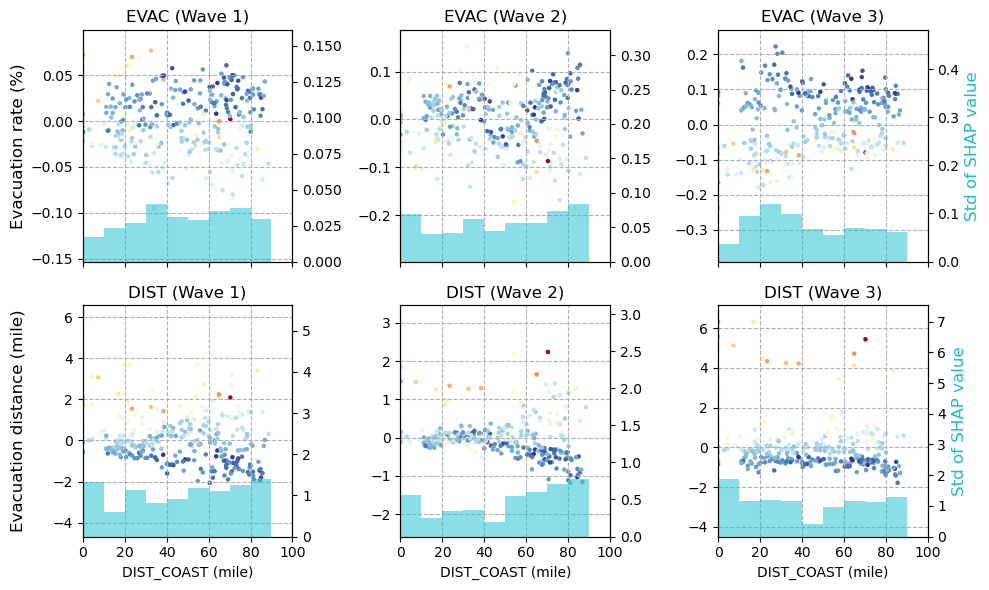

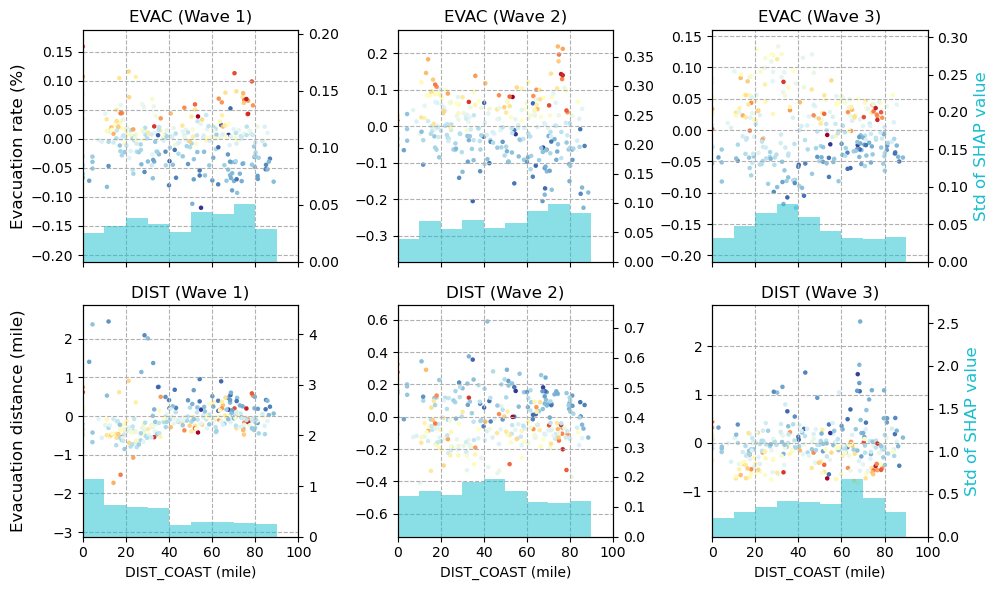

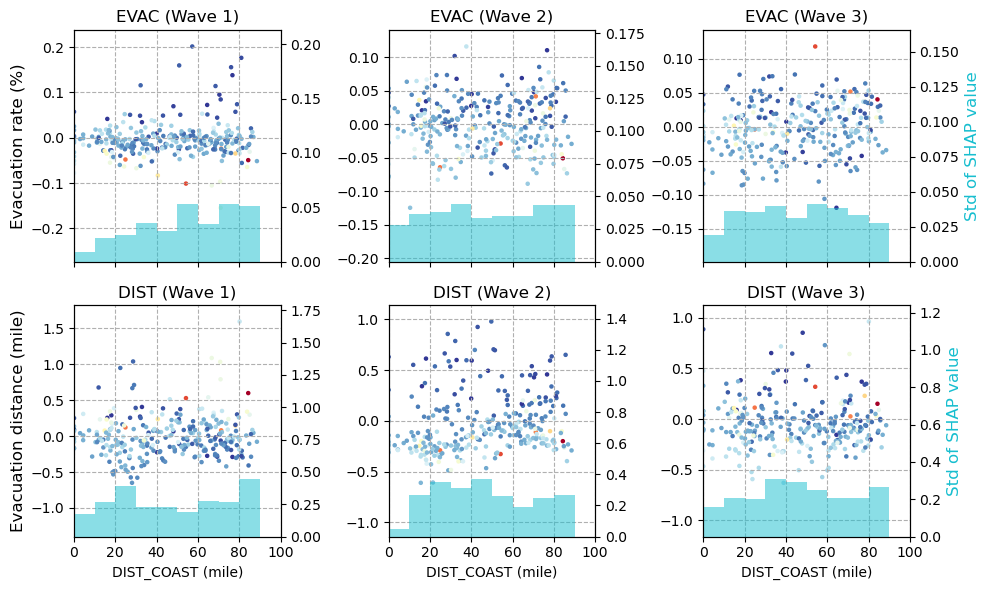

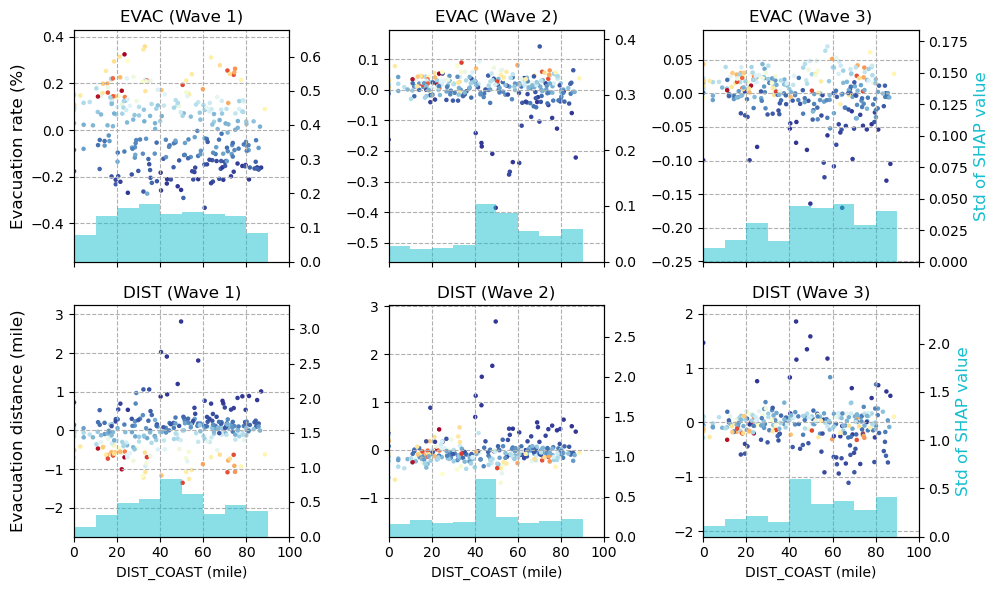

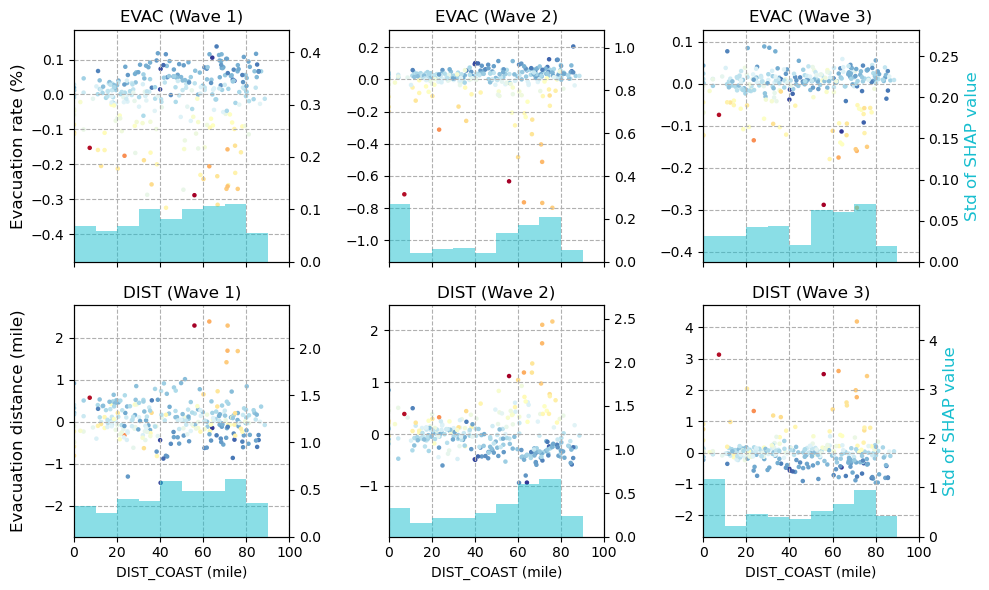

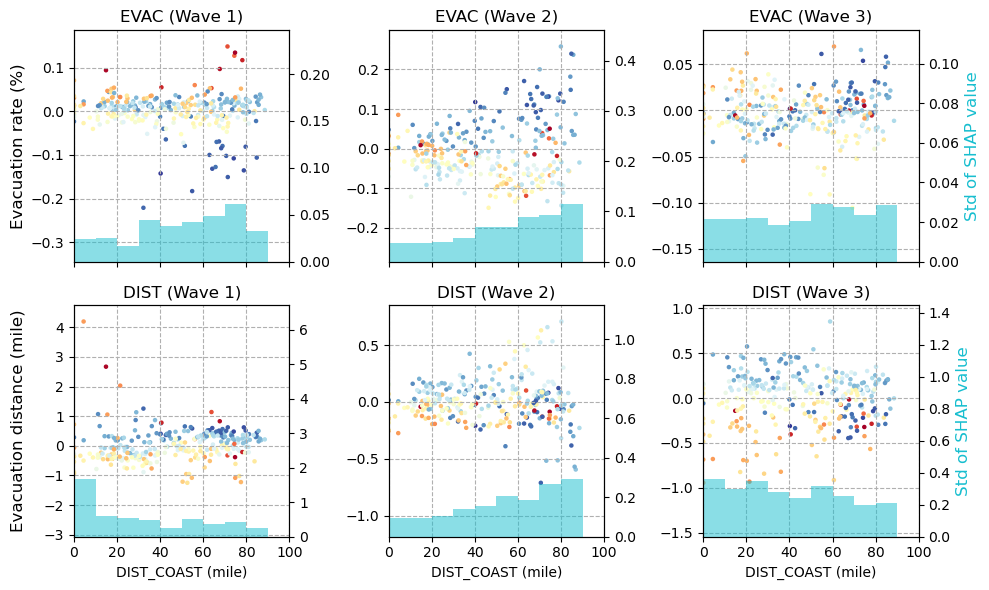

In [48]:
# iterate over all factor
for model in ['rf']:
      for factor in factors:
            #ks = [4,8,12,5,9,13,6,10,14,7,11,15]
            ks =  [4,8,12,6,10,14]
            fig, axs = plt.subplots(2, 3, figsize = (10, 6),sharex = True)

            j = 0
            for k in ks:
                  if 'CASE' in factor:
                        factor = f'CASE_{k//4}'
                  elif 'VAC' in factor:
                        factor = f'VAC_{k//4}'
                  data = np.zeros(res2[(seed, 'True', model, k)].shape)
                  for seed in seeds:
                        data += res2[(seed, 'True', model, k)]

                  data /= len(seeds)
                  
                  y = data[:, res[(seed, 100, 'True')][f'{model}_{k}'][-2].index(factor)] * res[(seed, 100, 'True')][f'{model}_{k}'][3].scale_[0] 
                  y_min = np.min(y)
                  y_max = np.max(y)

                  x = df_input[f'DIST_COAST'].values

                  colors = df_input[factor].values

                  axs[j //3, j % 3].scatter(x, y, s = 5, c = colors, cmap = 'RdYlBu_r')
                  axs[j //3, j % 3].set_title(names[k])
                  axs[j //3, j % 3].set_ylabel('')

                  # dashed line, behind the scatter plot, set it behind the scatter plot
                  axs[j //3, j % 3].grid(True, linestyle='--')

                  # for every 20 miles, aggregate the std, and plot as a bar plot in the secondary axis
                  x = np.linspace(0, 90, 10)
                  y2 = np.zeros(9)
                  for i in range(9):
                        ind = np.where((df_input['DIST_COAST'] > i*10) & (df_input['DIST_COAST'] <= (i+1)*10))
                        y2[i] = np.std(data[ind, res[(seed, 100, 'True')][f'{model}_{k}'][-2].index(factor)] * res[(seed, 100, 'True')][f'{model}_{k}'][3].scale_[0])
                  twinx = axs[j //3, j % 3].twinx()

                  twinx.bar(x[1:]-5, y2, width = 10, alpha = 0.5, color = 'C9')

                  if j % 3 == 2:
                        twinx.set_ylabel('Std of SHAP value', fontsize = 12, color = 'C9')

                  
                  axs[j //3, j % 3].set_ylim([y_min - 1/3*(y_max - y_min), y_max + 1/10*(y_max - y_min)])

                  twiny_max = np.max(y2)
                  twinx.set_ylim([0, 4*twiny_max])
                  
                  j += 1


            axs[0,0].set_ylabel('Evacuation rate (%)', fontsize = 12)
            # axs[1,0].set_ylabel('Return rate in 7 days (%)', fontsize = 12)
            axs[1,0].set_ylabel('Evacuation distance (mile)', fontsize = 12)
            # axs[3,0].set_ylabel('Evacuation cycle (day)', fontsize = 12)


            # axs[0,3].set_visible(False)

            # half the width of the figure
            # cbar = axs[0, 3].inset_axes([0.05, 0.1, 1, 1])
            # fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap='RdYlBu_r'),
            #             ax=cbar, orientation='vertical', label='COVID vaccination rate (%)')

            # for i in range(4): # Add x label y label and color bar
            for i in range(3):
                  axs[1, i].set_xlabel('DIST_COAST (mile)')
                  axs[1, i].set_xlim([0,100])
                  axs[1, i].set_xticks([0,20,40,60,80,100])
                  # axs[1, i].set_xticklabels([])

            fig.align_ylabels(axs[:, 0])
            fig.align_ylabels(axs[:, -1])

            plt.tight_layout()

            plt.savefig(f'../figs/shap_dist2{factor}_{model}.png', dpi = 300)
            plt.savefig(f'../figs/shap_dist2{factor}_{model}.pdf', dpi = 300)
      #       break
      # break

In [50]:
factors = ['CASE', 'VAC']

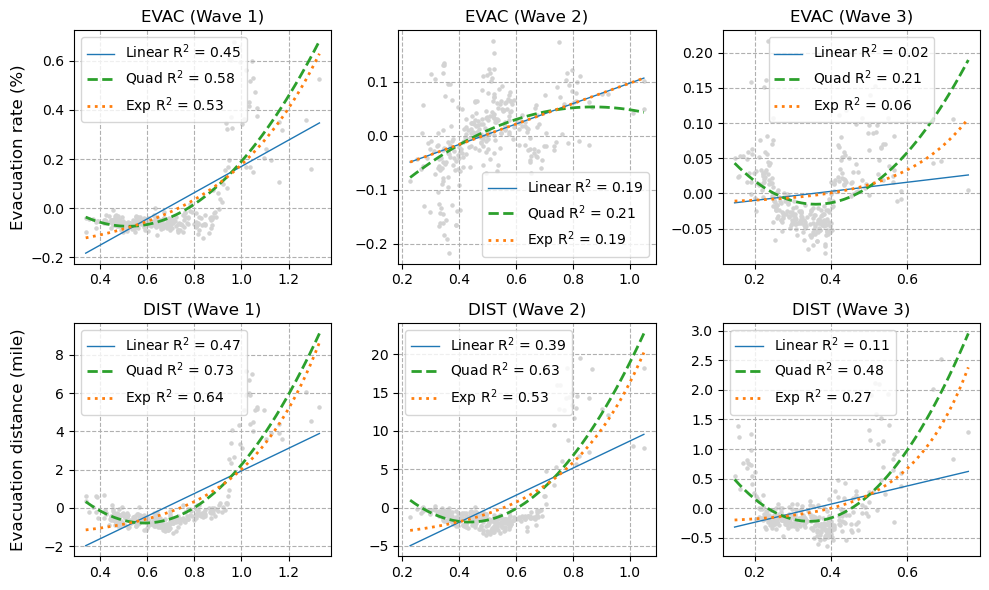

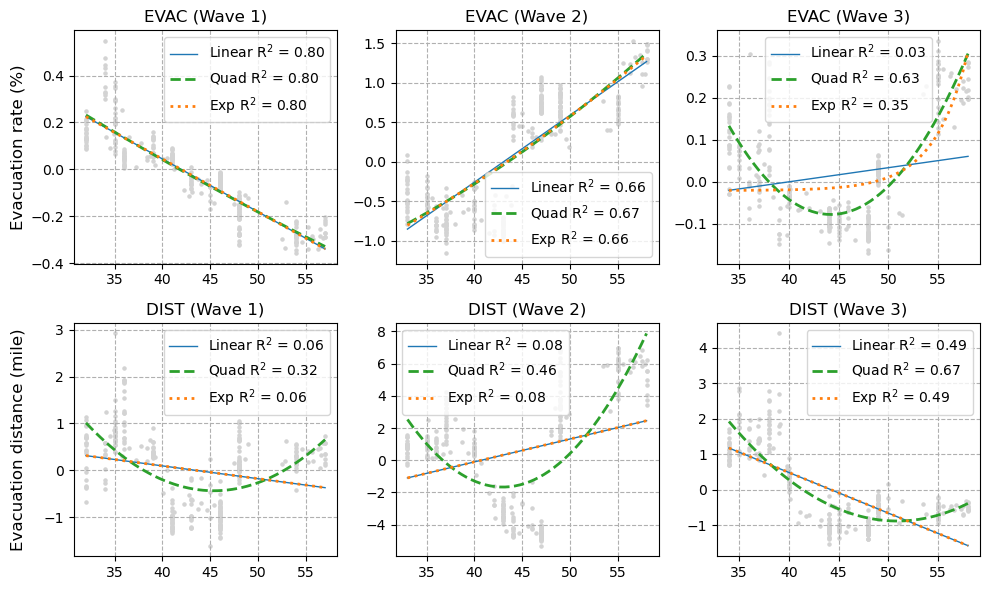

In [55]:
for model in ['rf']:
      for factor in factors:
            ks = [4,8,12,6,10,14] # [4,8,12,5,9,13,6,10,14,7,11,15]
            
            fig, axs = plt.subplots(2, 3, figsize = (10, 6))

            j = 0
            for k in ks:
                  if 'CASE' in factor:
                        factor = f'CASE_{k//4}'
                  elif 'VAC' in factor:
                        factor = f'VAC_{k//4}'

                  data = np.zeros(res2[(seed, 'True', model, k)].shape)
                  for seed in seeds:
                        data += res2[(seed, 'True', model, k)]

                  data /= len(seeds)
                  
                  y = data[:, res[(seed, 100, 'True')][f'{model}_{k}'][-2].index(factor)] * res[(seed, 100, 'True')][f'{model}_{k}'][3].scale_[0] 

                  # y =  data[:, res[(seed, 100, 'True')][f'{model}_{k}'][-1].index(f'VAC_{k//4}')]
                  x = df_input[factor]

                  colors = df_input[f'DIST_COAST'].values <0

                  # grey for distance > 75, orange for distance < 75
                  # axs[(j)//3, j % 3].scatter(x[colors], y[colors], marker = 'x', s = 8, color = 'lightgrey', alpha = 0.5)
                  axs[(j)//3, j % 3].scatter(x[~colors], y[~colors], s = 5, color = 'lightgrey')
                  axs[(j)//3, j % 3].set_title(names[k])
                  axs[(j)//3, j % 3].set_ylabel('')


                  # dashed line, behind the scatter plot
                  axs[(j)//3, j % 3].grid(True, linestyle='--')

                  # fit three lines for the scatter plot, linear, porabola, exponential
                  x1 = x[~colors]
                  y1 = y[~colors]
                  
                  exp_coef,_ = curve_fit(exp, x1, y1, (1, 0.1, -1), maxfev = 20000)
                  linear_coef,_ = curve_fit(linear, x1, y1)
                  porabola_coef,_ = curve_fit(parabola, x1, y1)

                  x1_ = np.linspace(np.min(x), np.max(x), 50)
                  exp_y1 = exp(x1_, *exp_coef)
                  linear_y1 = linear(x1_, *linear_coef)
                  porabola_y1 = parabola(x1_, *porabola_coef)

                  exp_r = 1-(np.linalg.norm(exp(x1, *exp_coef) - y1)**2 )/(np.linalg.norm(y1 - np.mean(y1))**2)
                  linear_r = 1-(np.linalg.norm(linear(x1, *linear_coef) - y1)**2)/(np.linalg.norm(y1 - np.mean(y1))**2)
                  porabola_r = 1-(np.linalg.norm(parabola(x1, *porabola_coef) - y1)**2)/(np.linalg.norm(y1 - np.mean(y1))**2)


                  # x2 = x[colors]
                  # y2 = y[colors]

                  # exp_coef2,_ = curve_fit(exp, x2, y2, (1, 0.1, -1), maxfev = 20000)
                  # linear_coef2,_ = curve_fit(linear, x2, y2)
                  # porabola_coef2,_ = curve_fit(parabola, x2, y2)

                  # x2_ = np.linspace(np.min(x), np.max(x), 50)
                  # exp_y2 = exp(x2_, *exp_coef2)
                  # linear_y2 = linear(x2_, *linear_coef2)
                  # porabola_y2 = parabola(x2_, *porabola_coef2)

                  # exp_r = 1-(np.linalg.norm(exp(x1, *exp_coef) - y1)**2 + np.linalg.norm(exp(x2, *exp_coef2) - y2)**2)/(np.linalg.norm(y1 - np.mean(y1))**2+ np.linalg.norm(y2 - np.mean(y2))**2)
                  # linear_r = 1-(np.linalg.norm(linear(x1, *linear_coef) - y1)**2+np.linalg.norm(linear(x2, *linear_coef2) - y2)**2)/(np.linalg.norm(y1 - np.mean(y1))**2+ np.linalg.norm(y2 - np.mean(y2))**2)
                  # porabola_r = 1-(np.linalg.norm(parabola(x1, *porabola_coef) - y1)**2+np.linalg.norm(parabola(x2, *porabola_coef2) - y2)**2)/(np.linalg.norm(y1 - np.mean(y1))**2+ np.linalg.norm(y2 - np.mean(y2))**2)

                  # plot the fitted curves and display the R-square
                  l1, = axs[(j)//3, j % 3].plot(x1_, linear_y1, '-', color = 'C0', lw = 1, label=f'Linear R$^2$ = {linear_r:.2f}')
                  l2, = axs[(j)//3, j % 3].plot(x1_, porabola_y1, '--', color = 'C2', lw = 2, label=f'Quad R$^2$ = {porabola_r:.2f}')
                  l3, = axs[(j)//3, j % 3].plot(x1_, exp_y1, ':', color = 'C1', lw = 2, label=f'Exp R$^2$ = {exp_r:.2f}')

                  # l4, = axs[(j)//3, j % 3].plot(x2_, linear_y2, '-', color = 'C0', lw = 1)
                  # l5, = axs[(j)//3, j % 3].plot(x2_, porabola_y2, '--', color = 'C2', lw = 2)
                  # l6, = axs[(j)//3, j % 3].plot(x2_, exp_y2, ':', color = 'C1', lw = 2)

                  axs[(j)//3, j % 3].legend(fontsize = 10)

                  if j // 3 == 2:
                        axs[3, j % 3].set_xlabel(factor)

                  j += 1

            # for i in range(2):
            #       axs[i, 0].set_ylabel('SHAP value', fontsize = 12)
            #       cmap = mpl.cm.cool
            #       norm = mpl.colors.Normalize(vmin=30, vmax=60)
            axs[0, 0].set_ylabel('Evacuation rate (%)', fontsize = 12)
            # axs[1, 0].set_ylabel('Return rate in 7 days (%)', fontsize = 12)
            axs[1, 0].set_ylabel('Evacuation distance (mile)', fontsize = 12)
            # axs[3, 0].set_ylabel('Evacuation cycle (day)', fontsize = 12)

            fig.align_ylabels(axs[:, 0])

            plt.tight_layout()

            plt.savefig(f'../figs/shap_fit2{factor}_{model}.png', dpi = 300)
            plt.savefig(f'../figs/shap_fit2{factor}_{model}.pdf', dpi = 300)

# Exam the residual

In [56]:
res = {}

for fold in range(5):
      for ratio in np.arange(100, 110, 10):
            for covid in ['False', 'True']:
                  with open(P.data + f'/res_{ratio}_{covid}_{fold}.pkl', 'rb') as f:
                        res[(fold, ratio, covid)] = pickle.load(f)

In [57]:
df = pd.concat([res[(i,100,'True')]['svm_10'][-1][['id','dist_wave2','geometry','resid']] for i in range(5)])

In [58]:
df['pred_y'] = df['resid']+df['dist_wave2']

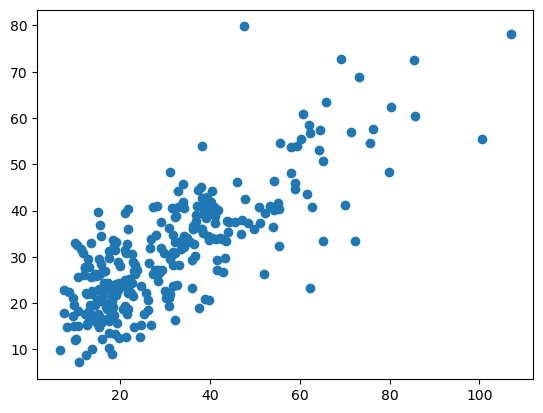

In [59]:
plt.scatter(df['dist_wave2'], df['pred_y'])